# Job configurations

We consider the following throughput computing scenario.
* Computations are done on a compute node with $P$ CPUs (cores) and with $M$ maximum memory.
* A total of $N$ independent computations has to be executed.
* Each of these computations takes equal time to execute.
* Each computation can be done using $p$ threads (or processes $\times$ threads), where $1 \le p \le P$.
* Each task requires at most $m \le M$ maximum memory.
* $n$ such computations can be done in parallel where $n \cdot p \le P$ and $n \cdot m \le M$.

Without loss of generality, we can set $N = P$.  In practice, $P$ is even, but not necessarily a power of 2.

The two most extreme job configurations are:
1. Run $P$ computations with $n = 1$ computations sequentially, using $p = P$ threads.
2. Run $P$ computations in parallel with $n = P$, using $p = 1$ thread for each.

However, many other job configurations are possible, e.g., run $P/2$ computations in parallel, using $p = 2$ threads for each, in 2 batches.  It is also important to realize that the nu not all the $P$ CPUs have to be used, i.e., $n \cdot p < P$ is a viable configuration, perhaps imposed by memory considerations or efficiency.

Below we will visualize the job configuration space.

## Requirements

In [1]:
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt

## Node specification & scheduler

To make the concepts more concrete, we assume that
* $P = 96$
* $M = 248$

This corresponds roughly to a dual socket Sapphire Rapid 
To clarify the relation with the Slurm job scheduler:
* $p$ corresponds to `cpus-per-task`
* $n$ corresponds to `ntasks`

The mapping of the memory $m$ required for an individual computation is not so straightforward since Slurm provides only `mem-per-cpu`, not per task.  So $m$ corresponds to `cpus-per0-task` $\cdot$ `mem-per-cpu` in practice.

## Case 1: default memory requirements

In this case, memory is not a concern.  The memory required per domputation is such that $P$ computations fit into the total memory $M$ of the node.

In [51]:
ntasks = [1, 2, 4, 6, 8, 12, 18, 24, 32, 48, 60, 72, 96]
cpus_per_task = [1, 2, 4, 8, 12, 24, 48, 96]
nr_cpus = 96

In [52]:
configs = np.array([(n, p) for n, p in itertools.product(ntasks, cpus_per_task) if n*p <= nr_cpus]).transpose()

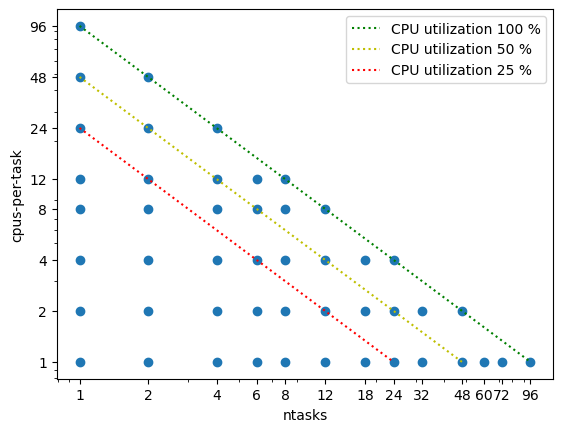

In [53]:
plt.loglog(configs[0, :], configs[1, :], 'o')
plt.xticks(ntasks, [str(n) for n in ntasks]);
plt.xlabel('ntasks');
plt.yticks(cpus_per_task, [str(p) for p in cpus_per_task]);
plt.ylabel('cpus-per-task');
plt.plot([1, 96], [96, 1], 'g:', label='CPU utilization 100 %')
plt.plot([1, 48], [48, 1], 'y:', label='CPU utilization 50 %')
plt.plot([1, 24], [24, 1], 'r:', label='CPU utilization 25 %')
plt.legend();

## Case 2: non-default memory requirements

In this case, the number of tasks $n$ that is run in parallel is limited by
$$
    n_{\mathrm{max}} = \left \lfloor \frac{M}{m} \right \rfloor
$$

In [66]:
ntasks = [1, 2, 4, 6, 8, 12, 18, 24, 32, 48, 60, 72, 96]
cpus_per_task = [1, 2, 4, 8, 12, 24, 48, 96]
nr_cpus = 96
max_mem = 248
m = 10
ntasks_max = max_mem//m
print(f'Maximum number of parallel tasks: {n_max}')

Maximum number of parallel tasks: 24


In [55]:
configs = np.array([(n, p) for n, p in itertools.product(ntasks, cpus_per_task) if n*p <= nr_cpus and n*m <= max_mem]).transpose()

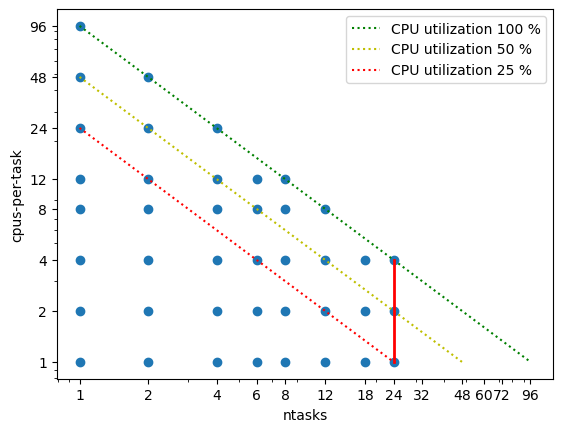

In [67]:
plt.loglog(configs[0, :], configs[1, :], 'o')
plt.xticks(ntasks, [str(n) for n in ntasks]);
plt.xlabel('ntasks');
plt.yticks(cpus_per_task, [str(p) for p in cpus_per_task]);
plt.ylabel('cpus-per-task');
plt.plot([1, 96], [96, 1], 'g:', label='CPU utilization 100 %')
plt.plot([1, 48], [48, 1], 'y:', label='CPU utilization 50 %')
plt.plot([1, 24], [24, 1], 'r:', label='CPU utilization 25 %')
plt.plot([ntasks_max, ntasks_max], [1, nr_cpus//ntasks_max], 'r', linewidth=2.0)
plt.legend();

It is clear that in this situation, the number of tasks $n$ that can be run on parallel is limited by the available memory in the node $M$.

## Measures

Although by itself the optimal configuration would be the one with the shortest runtime, it is also useful to quantify the efficiency.

The CPU utilization is given by
$$
    U(p, n) = \frac{n \cdot p}{P} \le 1
$$

Now the time to calculate all the $P$ computations using each of the configurations can be measured.  They are represented by $T(p, n)$, the time to perform $N =P$ computations using $n$ computations in parallel that each run with $p$ threads.

The base case is $T(1, 1)$, i.e., running the $N$ computation sequentially with $p = 1$.  The throughput speedup can now be defined as
$$
    S_{\mathrm{throughput}}(p, n) = \frac{T(1, 1)}{T(p, n)}
$$

The throughput efficiency can be defined as:
$$
    E_{\mathrm{throughput}}(p, n) = S_{\mathrm{throughput}}(p, n) \cdot U(p, n)
$$

The parallel speedup of a single computation is given by:
$$
    S(p, n) = \frac{T(1, 1)/P}{\frac{T(p, n)}{P/n}} = n \frac{T(1, 1)}{T(p, n)} = n \cdot S_{\mathrm{throughput}}(p, n)
$$

Hence the parallel efficiency of a single computation is:
$$
    E(p, n) = \frac{S(p, n)}{p} = \frac{n}{p} \cdot S_{\mathrm{throughput}}(p, n) = \frac{P}{p} E_{\mathrm{throughput}}(p, n)
$$

Note that $S(p, 1) = S_{\mathrm{throughput}}(p, 1)$ and $E(p, 1) = E_{\mathrm{throughput}}(p, 1)$ as expected.

## Experiments

In [5]:
def read_data(file_name):
    data = {}
    counts = collections.Counter()
    with open(file_name) as data_file:
        for line in data_file:
            if line[0].isdigit():
                ntasks, cpus_per_task, walltime = line.strip().split(',')
                idx = (int(ntasks), int(cpus_per_task))
                if idx not in data:
                    data[idx] = 0.0
                data[idx] += float(walltime)
                counts[idx] += 1
    return {
        idx: data[idx]/counts[idx] for idx in data
    }

In [15]:
data = read_data('slurm-job-configurations-2000.out')

In [9]:
data

{(1, 1): 1.866722895,
 (1, 2): 1.5921983581999999,
 (1, 4): 1.5226438044000001,
 (1, 8): 1.5243856058,
 (1, 12): 1.718924149,
 (1, 24): 1.4832092046,
 (1, 48): 1.4957973848000001,
 (1, 96): 1.6612823488,
 (2, 1): 1.710240236,
 (2, 2): 1.8969105794,
 (2, 4): 1.7623756166,
 (2, 8): 1.7532293442,
 (2, 12): 1.8021227524,
 (2, 24): 1.7049459258,
 (2, 48): 1.805389787,
 (4, 1): 2.2032070083999997,
 (4, 2): 2.3660267398,
 (4, 4): 2.4376103222,
 (4, 8): 2.5500480592,
 (4, 12): 2.377654598,
 (4, 24): 2.391008409,
 (6, 1): 2.637228459,
 (6, 2): 2.8991812078000003,
 (6, 4): 2.87131262,
 (6, 8): 2.6888969388,
 (6, 12): 2.7866653348,
 (8, 1): 3.3262348822,
 (8, 2): 3.1391134404,
 (8, 4): 3.3854819018,
 (8, 8): 3.3152568712,
 (8, 12): 3.4374472122,
 (12, 1): 4.453450588800001,
 (12, 2): 4.3128037672,
 (12, 4): 4.2406428232,
 (12, 8): 4.4024496396,
 (18, 1): 14.313933514999999,
 (18, 2): 7.9399547502,
 (18, 4): 6.0878696186,
 (24, 1): 7.5280919786,
 (24, 2): 7.6448922626,
 (24, 4): 7.7252566438,
 (32

In [13]:
def scale_data(data, nr_computations):
    scaled_data = {}
    for idx, walltime in data.items():
        ntasks, _ = idx
        nr_iterations = -(-nr_computations//ntasks)
        scaled_data[idx] = data[idx]*nr_iterations

    return scaled_data

In [25]:
scaled_data = scale_data(data, 96*2)

In [26]:
min(scaled_data, key=lambda idx: scaled_data[idx])

(48, 2)

In [28]:
max(scaled_data, key=lambda idx: scaled_data[idx])

(1, 1)

In [27]:
scaled_data

{(1, 1): 358.41079584,
 (1, 2): 305.70208477439996,
 (1, 4): 292.3476104448,
 (1, 8): 292.6820363136,
 (1, 12): 330.033436608,
 (1, 24): 284.77616728320004,
 (1, 48): 287.1930978816,
 (1, 96): 318.96621096959996,
 (2, 1): 164.183062656,
 (2, 2): 182.1034156224,
 (2, 4): 169.1880591936,
 (2, 8): 168.3100170432,
 (2, 12): 173.00378423040002,
 (2, 24): 163.6748088768,
 (2, 48): 173.317419552,
 (4, 1): 105.75393640319999,
 (4, 2): 113.5692835104,
 (4, 4): 117.0052954656,
 (4, 8): 122.4023068416,
 (4, 12): 114.127420704,
 (4, 24): 114.768403632,
 (6, 1): 84.391310688,
 (6, 2): 92.77379864960001,
 (6, 4): 91.88200384,
 (6, 8): 86.0447020416,
 (6, 12): 89.1732907136,
 (8, 1): 79.8296371728,
 (8, 2): 75.33872256960001,
 (8, 4): 81.2515656432,
 (8, 8): 79.5661649088,
 (8, 12): 82.4987330928,
 (12, 1): 71.25520942080001,
 (12, 2): 69.0048602752,
 (12, 4): 67.8502851712,
 (12, 8): 70.4391942336,
 (18, 1): 157.453268665,
 (18, 2): 87.3395022522,
 (18, 4): 66.9665658046,
 (24, 1): 60.2247358288,
 (

In [31]:
def reformat_data(data):
    ntasks, cpus_per_task, walltimes = [], [], []
    for idx, walltime in data.items():
        ntasks.append(idx[0])
        cpus_per_task.append(idx[1])
        walltimes.append(walltime)
    return ntasks, cpus_per_task, walltimes

In [33]:
ntasks, cpus_per_task, walltimes = reformat_data(scaled_data)

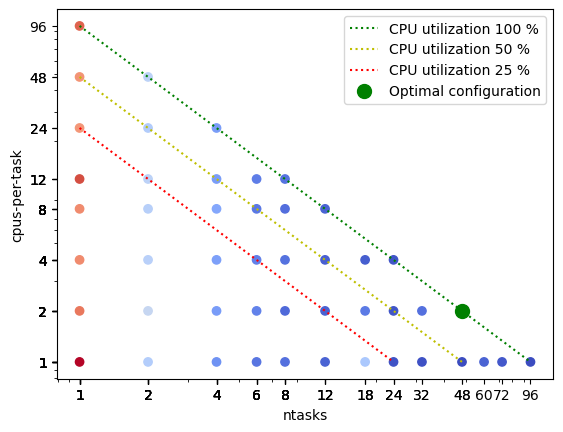

In [46]:
plt.plot([1, 96], [96, 1], 'g:', label='CPU utilization 100 %')
plt.plot([1, 48], [48, 1], 'y:', label='CPU utilization 50 %')
plt.plot([1, 24], [24, 1], 'r:', label='CPU utilization 25 %')
axis = plt.gca()
axis.scatter(ntasks, cpus_per_task, c=walltimes, cmap='coolwarm');
axis.set_xscale('log')
axis.set_yscale('log')
plt.xticks(ntasks, [str(n) for n in ntasks]);
plt.xlabel('ntasks');
plt.yticks(cpus_per_task, [str(p) for p in cpus_per_task]);
plt.ylabel('cpus-per-task');
best_config = min(scaled_data, key=lambda idx: scaled_data[idx])
plt.plot([best_config[0]], [best_config[1]], 'go', label='Optimal configuration', markersize=10)
plt.legend();